# 1000 State Walk

Anshuman Dash, Phillip Peng, Frank Yao



In [97]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from tqdm import tqdm 

Transistion of state

In [98]:
def transitions(state, step_size = 100):
	return [min(1001,max(0,state + dx)) for dx in range(-step_size,step_size+1) if dx != 0] if state not in (0,1001) else [state]
trs = transitions(950,step_size=100)
assert trs.count(1001)/len(trs)*100 == 25, "failing example test case"

Reward Function

In [99]:
def r(s):
    if s == 0:
        return -1
    if s == 1001:
        return 1
    return 0

One Transistion Step

In [100]:
def step(state):
    next_state = random.choices(transitions(state))[0]
    reward = r(next_state)
    return next_state, reward

In [116]:
def generate_episode(start_state = 500):
    states = []
    rewards = []
    state = start_state
    states.append(state)
    while(not (state == 1001 or state ==0)):
        state,reward = step(state)
        states.append(state)
        rewards.append(reward)
    return states, rewards

State Function

In [102]:
values = np.zeros(1002)

Value Iteration for True value of States

In [103]:
def value_iteration(values, iters=None, err = .001):
	iters = iters or float('inf')
	
	change = 9e9
	values[0] = -1
	values[1001] = 1
	it = 0
	while it < iters and change > err:
		it += 1
		print(it, change)
		old = values.copy()
		for i in range(1,1001):
			v = 0
			for a in transitions(i):
				v += values[a]
			values[i] = v/len(transitions(i))
		change = sum(abs(old - values))
	return values

In [104]:
value_iteration(values, iters = 1000, err = 0)

1 9000000000.0
2 80.47914143383869
3 52.20770855762527
4 40.54866238121564
5 34.116181516014
6 29.693334948528292
7 26.237436680426967
8 23.340771223223776
9 20.82513582571924
10 18.60461456247945
11 16.631058012257956
12 14.872115306541108
13 13.302463915558107
14 11.900654153284613
15 10.647710710325129
16 9.526934724232758
17 8.523627906673921
18 7.625034271985502
19 6.8200336124304215
20 6.098994098958336
21 5.453466299392069
22 4.875973027791056
23 4.359834272529244
24 3.8990333611969836
25 3.4881385675462733
26 3.122199734173699
27 2.796745739966595
28 2.5076966607369333
29 2.251363525708079
30 2.0244077340957665
31 1.823804370107565
32 1.6468332523803588
33 1.491041143355673
34 1.354221344369047
35 1.2344015543364821
36 1.1298005468735501
37 1.0388294741669446
38 0.9600622475893579
39 0.8922209717028318
40 0.8341571180248771
41 0.7848365543745648
42 0.7433228644901888
43 0.7087506066456796
44 0.6803230144247365
45 0.6572678288903071
46 0.6387519433564858
47 0.6237657449000099
48

array([-1.        , -0.92196046, -0.92071781, ...,  0.92071781,
        0.92196046,  1.        ])

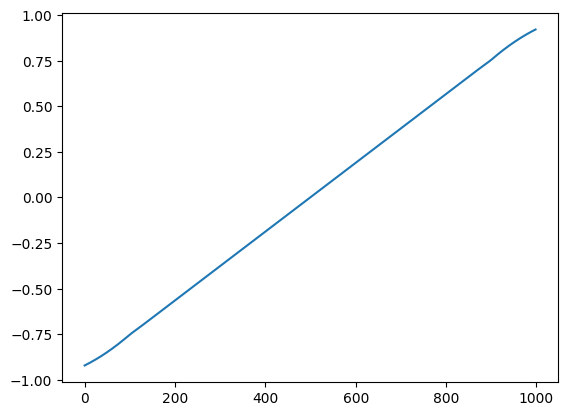

In [108]:
plt.plot(values[1:1000])
plt.show()

In [149]:
def state_aggregation(num_groups = 10, iters = 5000,gamma = 1 ,alpha = 2e-5):
	weights = np.zeros(num_groups)
	
	for it in tqdm(range(iters)):
		states, rewards = generate_episode()
		for i in range(len(states)-1):
			Gt = 0
			for j in range(i, len(rewards)):
				Gt += rewards[j]*pow(gamma, j-i)
			
			weights[int((states[i]-1)/100)] += alpha * (Gt - weights[int((states[i]-1)/100)])

	estimated_values = []
	for i in range(1,1001):
		estimated_values.append(weights[int((i-1)/100)])
	
	return estimated_values


In [176]:
aggregate_data_state_2e_5 = state_aggregation(iters=5000)
aggregate_data_state_2e_4 = state_aggregation(iters=5000, alpha = 2e-4)

100%|██████████| 5000/5000 [00:32<00:00, 153.92it/s]


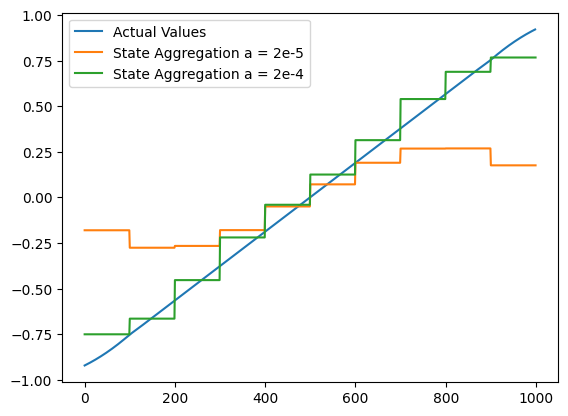

In [181]:
plt.plot(values[1:1000])
plt.plot(aggregate_data_state_2e_5)
plt.plot(aggregate_data_state_2e_4)
plt.legend(["Actual Values", "State Aggregation a = 2e-5", "State Aggregation a = 2e-4"])
plt.show()


In [151]:
def v_est_poly(s, w):
    v = 0
    for i in range(0, len(w)):
        v += pow((s-500)/500, i)*w[i]
    return v
def v_diff_poly(s,w):
    diff = [0]*len(w)
    for i in range(0, len(w)):
        diff[i] = pow((s-500)/500, i)
    return diff

def polynomial_basis(iters=5000, k=2, n=5, gamma=1, alpha = 1e-4):
    weights = np.zeros(n + 1)
    for it in tqdm(range(iters)):
        states, rewards = generate_episode()
        for i in range(len(states)-1):
            Gt = 0
            for j in range(i, len(rewards)):
                Gt += rewards[j]*pow(gamma, j-i)
            diff = v_diff_poly(states[i], weights)
            weights_updated = np.zeros(n + 1)
            for j in range(0,len(diff)):
                weights_updated[j] = weights[j] + alpha * (Gt - v_est_poly(states[i],weights)) * diff[j]
            weights = weights_updated.copy()
    
    estimated_values = []
    for i in range(1,1001):
        estimated_values.append(v_est_poly(i,weights))

    return estimated_values

In [179]:
aggregate_data_poly = polynomial_basis()

100%|██████████| 5000/5000 [00:46<00:00, 106.79it/s]


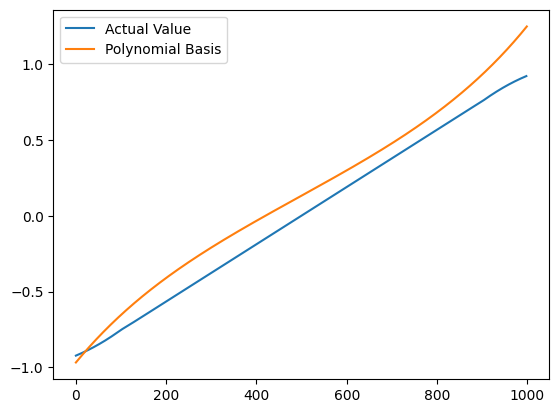

In [183]:
plt.plot(values[1:1000])
plt.plot(aggregate_data_poly)

plt.legend(["Actual Value", "Polynomial Basis"])
plt.show()

In [172]:
def v_est_fourier(s, w):
    v = 0
    for i in range(0, len(w)):
        v += np.cos(np.pi * i * (s)/1000)*w[i]
    return v
def v_diff_fourier(s,w):
    diff = [0]*len(w)
    for i in range(0, len(w)):
        diff[i] = np.cos(np.pi*i*(s)/1000)
    return diff


def fourier_basis( iters =5000,n=5 , gamma =1, alpha = 5e-5):
    weights = [0]*(n+1)
    for it in tqdm(range(iters)):
        states, rewards = generate_episode()
        for i in range(len(states)-1):
            Gt = 0
            for j in range(i, len(rewards)):
                Gt += rewards[j]*(gamma**(j-i))
            diff = v_diff_fourier(states[i],weights)
            new_weights = [0]*(n+1)
            for j in range(len(diff)):
                new_weights[j] = weights[j] + alpha*(Gt - v_est_fourier(states[i],weights))*diff[j]
            weights = new_weights
    estimated_values = []
    for i in range(1,1001):
        estimated_values.append(v_est_fourier(i,weights))

    return estimated_values


In [175]:
aggregate_data_fourier_5e_5= fourier_basis()
aggregate_data_fourier_2e_4 = fourier_basis(alpha=2e-4)

100%|██████████| 5000/5000 [00:55<00:00, 90.78it/s] 


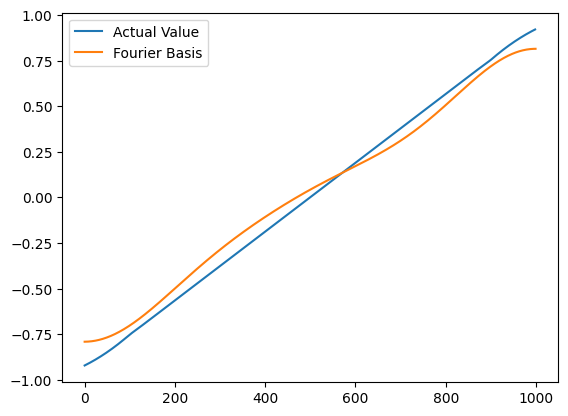

In [178]:
plt.plot(values[1:1000])
# plt.plot(aggregate_data_state_2e_4)
# plt.plot(aggregate_data_state_2e_5)
# plt.plot(aggregate_data_poly)
plt.plot(aggregate_data_fourier_5e_5)
# plt.plot(aggregate_data_fourier_2e_4)

plt.legend(["Actual Value", "Fourier Basis"])
plt.show()